# Predicting house prices: a regression example

In [1]:
from tensorflow import keras as keras

## The Boston Housing Price dataset

In [2]:
(train_data, train_targets), (test_data, test_targets) =  keras.datasets.boston_housing.load_data()

In [3]:
train_data.shape

(404, 13)

In [4]:
test_data.shape

(102, 13)

我们有404 个训练样本和102 个测试样本，每个样本都有13 个数值特征，比如人均犯罪率、每个住宅的平均房间数、高速公路可达性等。目标是房屋价格的中位数，单位是千美元

In [5]:
train_targets

array([15.2, 42.3, 50. , 21.1, 17.7, 18.5, 11.3, 15.6, 15.6, 14.4, 12.1,
       17.9, 23.1, 19.9, 15.7,  8.8, 50. , 22.5, 24.1, 27.5, 10.9, 30.8,
       32.9, 24. , 18.5, 13.3, 22.9, 34.7, 16.6, 17.5, 22.3, 16.1, 14.9,
       23.1, 34.9, 25. , 13.9, 13.1, 20.4, 20. , 15.2, 24.7, 22.2, 16.7,
       12.7, 15.6, 18.4, 21. , 30.1, 15.1, 18.7,  9.6, 31.5, 24.8, 19.1,
       22. , 14.5, 11. , 32. , 29.4, 20.3, 24.4, 14.6, 19.5, 14.1, 14.3,
       15.6, 10.5,  6.3, 19.3, 19.3, 13.4, 36.4, 17.8, 13.5, 16.5,  8.3,
       14.3, 16. , 13.4, 28.6, 43.5, 20.2, 22. , 23. , 20.7, 12.5, 48.5,
       14.6, 13.4, 23.7, 50. , 21.7, 39.8, 38.7, 22.2, 34.9, 22.5, 31.1,
       28.7, 46. , 41.7, 21. , 26.6, 15. , 24.4, 13.3, 21.2, 11.7, 21.7,
       19.4, 50. , 22.8, 19.7, 24.7, 36.2, 14.2, 18.9, 18.3, 20.6, 24.6,
       18.2,  8.7, 44. , 10.4, 13.2, 21.2, 37. , 30.7, 22.9, 20. , 19.3,
       31.7, 32. , 23.1, 18.8, 10.9, 50. , 19.6,  5. , 14.4, 19.8, 13.8,
       19.6, 23.9, 24.5, 25. , 19.9, 17.2, 24.6, 13

## Preparing the data

将取值范围差异很大的数据输入到神经网络中，这是有问题的。网络可能会自动适应这种取值范围不同的数据，但学习肯定变得更加困难。对于这种数据，普遍采用的最佳实践是对每个特征做标准化，即对于输入数据的每个特征（输入数据矩阵中的列），减去特征平均值，再除以标准差，这样得到的特征平均值为0，标准差为1

**注意，用于测试数据标准化的均值和标准差都是在训练数据上计算得到的。在工作流程中，你不能使用在测试数据上计算得到的任何结果，即使是像数据标准化这么简单的事情也不行**

In [6]:
mean = train_data.mean(axis=0)
train_data -= mean

std = train_data.std(axis=0)
train_data /= std

test_data -= mean
test_data /= std

## Building our network

In [7]:
from tensorflow.keras import models
from tensorflow.keras import layers

def build_model():
    # Because we will need to instantiate
    # the same model multiple times,
    # we use a function to construct it.
    model = models.Sequential()
    model.add(layers.Dense(64, activation='relu',
                           input_shape=(train_data.shape[1],)))
    model.add(layers.Dense(64, activation='relu'))
    model.add(layers.Dense(1))
    model.compile(optimizer='rmsprop', loss='mse', metrics=['mae'])
    return model

网络的最后一层只有一个单元，没有激活，是一个线性层。这是标量回归（标量回归是预测单一连续值的回归）的典型设置。添加激活函数将会限制输出范围。

## Validating our approach using K-fold validation

In [8]:
import numpy as np

k = 4
num_val_samples = len(train_data) // k
num_epochs = 100
all_scores = []

for i in range(k):
    print('processing fold #', i)
    # Prepare the validation data: data from partition # k
    val_data = train_data[i * num_val_samples: (i + 1) * num_val_samples]
    val_targets = train_targets[i * num_val_samples: (i + 1) * num_val_samples]

    # Prepare the training data: data from all other partitions
    partial_train_data = np.concatenate(
        [train_data[:i * num_val_samples],
         train_data[(i + 1) * num_val_samples:]],
        axis=0)
    partial_train_targets = np.concatenate(
        [train_targets[:i * num_val_samples],
         train_targets[(i + 1) * num_val_samples:]],
        axis=0)

    # Build the Keras model (already compiled)
    model = build_model()
    # Train the model (in silent mode, verbose=0)
    model.fit(partial_train_data, partial_train_targets,
              epochs=num_epochs, batch_size=1, verbose=0)
    # Evaluate the model on the validation data
    val_mse, val_mae = model.evaluate(val_data, val_targets, verbose=0)
    all_scores.append(val_mae)

processing fold # 0
processing fold # 1
processing fold # 2
processing fold # 3


In [9]:
all_scores

[2.3799927, 2.6133533, 2.553841, 2.4885726]

In [10]:
np.mean(all_scores)

2.50894

每次运行模型得到的验证分数有很大差异，从2.6 到3.2 不等。平均分数（3.0）是比单一分数更可靠的指标——这就是K 折交叉验证的关键。在这个例子中，预测的房价与实际价格平均相差3000 美元，考虑到实际价格范围在10 000~50 000 美元，这一差别还是很大的。我们让训练时间更长一点，达到500 个轮次。为了记录模型在每轮的表现，我们需要修改训练循环，以保存每轮的验证分数记录。

In [11]:
from tensorflow.keras import backend as K

# Some memory clean-up
K.clear_session()

In [14]:
num_epochs = 500
all_mae_histories = []
for i in range(k):
    print('processing fold #', i)
    # Prepare the validation data: data from partition # k
    val_data = train_data[i * num_val_samples: (i + 1) * num_val_samples]
    val_targets = train_targets[i * num_val_samples: (i + 1) * num_val_samples]

    # Prepare the training data: data from all other partitions
    partial_train_data = np.concatenate(
        [train_data[:i * num_val_samples],
         train_data[(i + 1) * num_val_samples:]],
        axis=0)
    partial_train_targets = np.concatenate(
        [train_targets[:i * num_val_samples],
         train_targets[(i + 1) * num_val_samples:]],
        axis=0)

    # Build the Keras model (already compiled)
    model = build_model()
    # Train the model (in silent mode, verbose=0)
    history = model.fit(partial_train_data, partial_train_targets,
                        validation_data=(val_data, val_targets),
                        epochs=num_epochs, batch_size=1, verbose=0)
#     print(history.history.keys())
    mae_history = history.history['val_mae']
    all_mae_histories.append(mae_history)

processing fold # 0
processing fold # 1
processing fold # 2
processing fold # 3


计算每个轮次中所有折MAE 的平均值

In [15]:
average_mae_history = [
    np.mean([x[i] for x in all_mae_histories]) for i in range(num_epochs)]

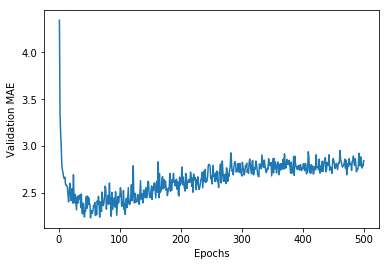

In [17]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.plot(range(1, len(average_mae_history) + 1), average_mae_history)
plt.xlabel('Epochs')
plt.ylabel('Validation MAE')
plt.show()

因为纵轴的范围较大，且数据方差相对较大，所以难以看清这张图的规律。我们来重新绘制一张图。
- 删除前 10 个数据点，因为它们的取值范围与曲线上的其他点不同。
- 将每个数据点替换为前面数据点的指数移动平均值，以得到光滑的曲线。

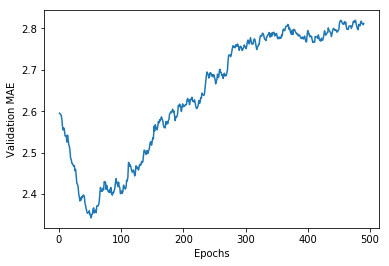

In [18]:
def smooth_curve(points, factor=0.9):
    smoothed_points = []
    for point in points:
        if smoothed_points:
            previous = smoothed_points[-1]
            smoothed_points.append(previous * factor + point * (1 - factor))
        else:
            smoothed_points.append(point)
    return smoothed_points

smooth_mae_history = smooth_curve(average_mae_history[10:])

%matplotlib inline
plt.plot(range(1, len(smooth_mae_history) + 1), smooth_mae_history)
plt.xlabel('Epochs')
plt.ylabel('Validation MAE')
plt.show()

验证 MAE 在 80 轮后不再显著降低，之后就开始过拟合

完成模型调参之后（除了轮数，还可以调节隐藏层大小），你可以使用最佳参数在所有训练数据上训练最终的生产模型，然后观察模型在测试集上的性能。

In [21]:
# Get a fresh, compiled model.
model = build_model()
# Train it on the entirety of the data.
model.fit(train_data, train_targets,
          epochs=80, batch_size=16, verbose=0)
test_mse_score, test_mae_score = model.evaluate(test_data, test_targets)

102/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================

In [22]:
test_mae_score

2.6705089